In [2]:
import random
import json
import re
import os
import bz2
import spacy
nlp = spacy.load('en', disable=['ner', 'textcat'])

from textstat.textstat import textstat
import matplotlib.pyplot as plt

from nlgeval import compute_metrics
import kenlm

# Functions to read and prepare data

In [3]:
# extract complex and simple sentences and text category 
# from all data for one sentence in DBPedia dataset

def parseSentenceData(data):
    data = data.strip().split("\n\n")
    
    complexsentdata = data[0].strip().split("\n")
    complexid = int(complexsentdata[0].split("-")[1].strip())
    complexsent = complexsentdata[1].strip()

    cat = '' 
    mr_dict = {}
    # Collect all complex mrs
    for item in data[1:]:
        if re.match('COMPLEX-'+str(complexid)+':MR-[0-9]*\n', item):
            # print item
            mrdata = item.strip().split("\n")
            mrid = mrdata[0]
            mr = mrdata[1]
            if re.match('category=[a-zA-Z]* eid=Id[0-9]* size=[0-9]*', mr):
                cat = mr.strip().split(' ')[0].split('=')[1]
            mr_dict[mrid] = [mr, {}]
    
    simpsents = {}
    for item in data[1:]:
        if re.match('COMPLEX-'+str(complexid)+':MR-[0-9]*:SIMPLE-[0-9]*\n', item):
            
            mrid = ":".join(item.strip().split("\n")[0].split(":")[:2])

            sents = (" ".join(item.strip().split("\n")[1:])).strip()
            
            if sents not in simpsents:
                simpsents[sents] = 1

            if sents not in mr_dict[mrid][1]:
                mr_dict[mrid][1][sents] = 1

    return complexsent, simpsents, cat

In [42]:
# remove some frequent garbage from sentences 
def preprocessSentence(text):
    text = re.sub('-LRB-(.*?)-RRB-', '', text)
    text = re.sub('^\"', '', text)
    text = re.sub('\"$', '', text)
    return text

In [37]:
# Read DBPedia dataset
def readDBPediaData(compl_to_sim):
    filename = '../dataset/complexsimple.txt.bz2'
    with bz2.BZ2File(filename, "r") as content:         
        sentdata = []
        i = 0
        close_to_geo_categories = ['Monument', 'City', 'Airport', 'Building']

        for line in content:
            if len(sentdata) == 0:
                sentdata.append(line)
            else:
                if re.match('COMPLEX-[0-9]*\n', line):
                    complexsent, simpsents, cat = parseSentenceData("".join(sentdata))
                    simple_sen = simpsents.keys()[0]
                    
                    if (cat in close_to_geo_categories) and (len(simple_sen) > 0):
                        compl_to_sim[preprocessSentence(complexsent)] = preprocessSentence(simple_sen)
                    sentdata = [line]
                else:
                    sentdata.append(line)
    return compl_to_sim

In [43]:
# read Newsela dataset
def readNewselaData(compl_to_sim):
    with bz2.BZ2File('../dataset/clear_newsela.txt.bz2', "r") as content:         
        for line in content:
            texts = line.split('\t')

            if len(texts) != 3:
#                 print 'wrong line: ', len(texts), line
                continue
            if (len(texts[0]) < 10) or (len(texts[1]) < 10):
#                 print 'empty line: ', line
                continue
                
            compl_to_sim[preprocessSentence(texts[0])] = preprocessSentence(texts[1])
    return compl_to_sim

In [44]:
# split data to train and test set
def splitTrainTest(compl_to_sim):
    train = {}
    test = {}

    for compl, sim in compl_to_sim.iteritems():
        try:
            sim_u = sim.encode('utf-8')
            compl_u = compl.encode('utf-8')
        except:
            continue
        r = random.random()
        if r < 0.8:
            train[compl] = sim
        else:
            test[compl] = sim
    return train, test

# Functions for baseline logic

In [8]:
# Some words does not make sense (or change sense) when used without dependent clause.
# For example, "part" in "part of the U.S.A." or "length" in "length of 4000".
# This function builds a clause required to save such information.

def getReasonableChunk(word, doc):
    chunk_words = []
    if word.pos_ == 'PROPN':
        try:
            chunks = list(x for x in doc.noun_chunks if x.root == word)[0]
            chunk_words.extend(list(x for x in chunks))
        except:
            print 'no chunk with root ' + word.text
    elif word.pos_ == 'NOUN':
        nummods = list(x for x in word.children if x.dep_ == 'nummod')
        chunk_words.append(word)
        chunk_words.extend(nummods)
        
        dets = list(x for x in word.children if x.dep_ == 'det')
        chunk_words.extend(dets)
        
        compunds = list(x for x in word.children if x.dep_ == 'compound')
        chunk_words.extend(compunds)
    else:
        chunk_words.append(word)

        
    prepositions = list(x for x in word.children if x.dep_ == 'prep')
    pobjects = []
    for prep in prepositions:
        pobjects = list(x for x in prep.children if x.dep_ == 'pobj')
        if len(pobjects) > 0:
            chunk_words.append(prep)
            for s in pobjects:
                chunk_words.extend(getReasonableChunk(s, doc))
                    
    return chunk_words

In [9]:
# convert list of lists of words to text (form readable sentences)
def wordsToSimpleText(sentence_words):
    text = ''
    for words in sentence_words:
        sentence_text = ''
        for word in words:
            sentence_text += word.text + ' '
            
        if len(sentence_text) > 0:
            sentence_text = sentence_text[0].upper() + sentence_text[1:]
            sentence_text += '. '
            
            text += sentence_text
    return text

In [10]:
# main baseline function
# build set of simple sentences based on each verb's subtree in a complex sentence
# input: spacy.doc with complex sentences
# output: text with one or more simple sentences

def subjVerbObjToSentence(sentence):
    verbs = list(x for x in sentence if x.pos_ == 'VERB')
    new_sentences = []
    for v in verbs:
        new_sent_words = [v]
        has_sence = False
        
        ouxilaries = list(x for x in v.children if (x.dep_ == 'aux') or (x.dep_ == 'auxpass'))
        new_sent_words.extend(ouxilaries)
        
        subjects = list(x for x in v.children if (x.dep_ == 'nsubj') or (x.dep_ == 'nsubjpass'))
        if len(subjects) > 0:
            has_sence = True
            for s in subjects:
                new_sent_words.extend(getReasonableChunk(s, sentence))

        attributes = list(x for x in v.children if (x.dep_ == 'attr'))
        if len(attributes) > 0:
            has_sence = True
            for s in attributes:
                new_sent_words.extend(getReasonableChunk(s, sentence))
                
        dobjects = list(x for x in v.children if x.dep_ == 'dobj')
        if len(dobjects) > 0:
            has_sence = True
            for s in dobjects:
                new_sent_words.extend(getReasonableChunk(s, sentence))
            
        prepositions = list(x for x in v.children if x.dep_ == 'prep')
        pobjects = []
        for prep in prepositions:
            pobjects = list(x for x in prep.children if x.dep_ == 'pobj')
            if len(pobjects) > 0:
                has_sence = True
                new_sent_words.append(prep)
                for s in pobjects:
                    new_sent_words.extend(getReasonableChunk(s, sentence))

        if v.dep_ == 'conj':
            subjects = list(x for x in v.head.children if (x.dep_ == 'nsubj') or (x.dep_ == 'nsubjpass'))
            if len(subjects) > 0:
                has_sence = True
                for s in subjects:
                    new_sent_words.extend(getReasonableChunk(s, sentence))
        
        new_sent_words = sorted(new_sent_words, key=lambda x: x.i)
        
        if has_sence == True:
            new_sentences.append(new_sent_words)
    
    simple_text = wordsToSimpleText(new_sentences)
    return simple_text


# Functions for post-processing

In [72]:
# get sequence of POS tags for a sentence
def buildSentenceTemplate(sent):
    templ = ''
    for word in sent:
        if word.pos_ != 'SPACE':
            templ += word.pos_ + '_'
            
    templ = re.sub('PROPN_PUNCT_', 'PROPN_', templ)
    templ = re.sub('(PROPN_)+', 'NOUN_', templ)
    templ = re.sub('NUM_PUNCT_NUM_', 'NUM_', templ)
    templ = re.sub('(PUNCT_)+', 'PUNCT_', templ)
    templ = re.sub('PUNCT_$', '', templ)
    
    return templ

In [73]:
# wide list of sentence templates using sentences from text
# text - plain text of one or more sentences
# sentence_templates - dictionary (template text -> frequency)

def addTemplatesStats(texts, sentence_templates):
    for text in texts:
        doc = nlp(text.decode('utf-8'), disable=['ner', 'textcat'])
        for sent in doc.sents:
            templ = buildSentenceTemplate(sent)
            if not sentence_templates.has_key(templ):
                sentence_templates[templ] = 0
            sentence_templates[templ] += 1

    return sentence_templates   

In [74]:
# get list of "valid" sentence templates - ones that appears 
# in sentence_templates dictionary more than frequency_threshold times
def getPossibleSentenceTemplates(frequency_threshold, sentence_templates):
    valid_templates = []
    for templ, frequency in sentence_templates.iteritems():
        if frequency >= frequency_threshold:
            valid_templates.append(templ)
            
    return valid_templates

In [78]:
# check if template of sentence is in list of 'valid' templates
def hasValidTemplate(valid_templates, sentence):
    template = buildSentenceTemplate(sentence)
    if template in valid_templates:
        return True
    else:
        return False

In [138]:
# Remove sentences with not 'valid' template from the given text
def removeUnlikeSentences(text, valid_templates):
    final_text = ''
    rejected_sents = []
    doc = nlp(text.decode('utf-8'), disable=['ner', 'textcat'])
    for sent in doc.sents:
        if hasValidTemplate(valid_templates, sent) == True:
            final_text += sent.text + ' '
        else:
            rejected_sents.append(sent.text)
    return final_text, rejected_sents

# Read and preprocess data

In [135]:
## main1 ##
compl_to_sim = {}
compl_to_sim = readNewselaData(compl_to_sim)
compl_to_sim = readDBPediaData(compl_to_sim)
train, test = splitTrainTest(compl_to_sim)
print len(train), len(test)

5398 1359


In [136]:
# get useful statistics from the whole dataset 
sentence_templates = {}
sentence_templates = addTemplatesStats(train.values(), sentence_templates)
sentence_templates = addTemplatesStats(test.values(), sentence_templates)
valid_templates = getPossibleSentenceTemplates(1, sentence_templates)
print len(valid_templates)

3972


# Get some examples of baseline results

In [165]:
i = 0
for compl, sim in test.iteritems():
    i += 1
    if i > 20:
        break
    doc = nlp(compl.decode('utf-8'), disable=['ner', 'textcat'])
    simple_text = subjVerbObjToSentence(doc)
#     simple_text, rejected = removeUnlikeSentences(simple_text, valid_templates)
    print '\n\ncomplex sentence: '
    print doc.text
    print 'simple_text_given: '
    print sim
    print 'simple_text_generated: '
    print simple_text
#     print 'rejected sentences: '
#     print rejected



complex sentence: 
Anaheim , California has a total area of 131.6 sq km and the area codes are 657 and 714 .
simple_text_given: 
Anaheim in California has the area code : 657 , 714 . The total area of Anaheim California is 131.6 sq km .
simple_text_generated: 
Anaheim has a area of 131.6 sq km . Anaheim the area codes are 657 . 


complex sentence: 
The Asilomar Conference Grounds constructed in 1913 at Pacific Grove , California is based on the architecture style of `` Arts and Crafts Movement and American craftsman Bungalows '' .
simple_text_given: 
Asilomar Conference Grounds are located in Pacific Grove , California . The Asilomar Conference Grounds was constructed in 1913 . Asilomar Conference Grounds is designed based on the architecture style of `` Arts and Crafts Movement and American craftsman Bungalows '' .
simple_text_generated: 
The Asilomar Conference Grounds constructed in 1913 at Pacific Grove . California is based on the architecture style of `` Arts and Crafts Moveme

# Get baseline results for all items in test set

In [155]:
## main2 ##
baseline_result = {}
for compl, sim in test.iteritems():
    doc = nlp(compl.decode('utf-8'), disable=['ner', 'textcat'])
    simple_text = subjVerbObjToSentence(doc)
#     simple_text, rejected = removeUnlikeSentences(simple_text, valid_templates)
    baseline_result[compl] = simple_text

# Calculate simplicity metrics

In [156]:
## main 3 ##
simplicity_metrics = {}

simplicity_metrics["lexicon_count"] = {}
simplicity_metrics["lexicon_count"]["compl"] = []
simplicity_metrics["lexicon_count"]["simple_gold"] = []
simplicity_metrics["lexicon_count"]["baseline"] = []

simplicity_metrics["flesch_reading_ease"] = {}
simplicity_metrics["flesch_reading_ease"]["compl"] = []
simplicity_metrics["flesch_reading_ease"]["simple_gold"] = []
simplicity_metrics["flesch_reading_ease"]["baseline"] = []

simplicity_metrics["flesch_kincaid"] = {}
simplicity_metrics["flesch_kincaid"]["compl"] = []
simplicity_metrics["flesch_kincaid"]["simple_gold"] = []
simplicity_metrics["flesch_kincaid"]["baseline"] = []

simplicity_metrics["automated_readability"] = {}
simplicity_metrics["automated_readability"]["compl"] = []
simplicity_metrics["automated_readability"]["simple_gold"] = []
simplicity_metrics["automated_readability"]["baseline"] = []

simplicity_metrics["difficult_words"] = {}
simplicity_metrics["difficult_words"]["compl"] = []
simplicity_metrics["difficult_words"]["simple_gold"] = []
simplicity_metrics["difficult_words"]["baseline"] = []

simplicity_metrics["linsear_write"] = {}
simplicity_metrics["linsear_write"]["compl"] = []
simplicity_metrics["linsear_write"]["simple_gold"] = []
simplicity_metrics["linsear_write"]["baseline"] = []

for compl, sim in test.iteritems():
    try:
        words_count = textstat.lexicon_count(compl)
        simplicity_metrics["lexicon_count"]["compl"].append(words_count)
        simplicity_metrics["flesch_reading_ease"]["compl"].append(textstat.flesch_reading_ease(compl))
        simplicity_metrics["flesch_kincaid"]["compl"].append(textstat.flesch_kincaid_grade(compl))
        simplicity_metrics["automated_readability"]["compl"].append(textstat.automated_readability_index(compl))
        simplicity_metrics["difficult_words"]["compl"].append(textstat.difficult_words(compl) / float(words_count))
        simplicity_metrics["linsear_write"]["compl"].append(textstat.linsear_write_formula(compl))
    except:
        print 'complex evaluation error'
        continue
    
    try:
        words_count = textstat.lexicon_count(sim)
        simplicity_metrics["lexicon_count"]["simple_gold"].append(words_count)
        simplicity_metrics["flesch_reading_ease"]["simple_gold"].append(textstat.flesch_reading_ease(sim))
        simplicity_metrics["flesch_kincaid"]["simple_gold"].append(textstat.flesch_kincaid_grade(sim))
        simplicity_metrics["automated_readability"]["simple_gold"].append(textstat.automated_readability_index(sim))
        simplicity_metrics["difficult_words"]["simple_gold"].append(textstat.difficult_words(sim) / float(words_count))
        simplicity_metrics["linsear_write"]["simple_gold"].append(textstat.linsear_write_formula(sim))
    except:
        print 'simple_gold evaluation error'
        continue
        
    try:
        words_count = textstat.lexicon_count(baseline_result[compl])
        simplicity_metrics["lexicon_count"]["baseline"].append(words_count)
        simplicity_metrics["flesch_reading_ease"]["baseline"].append(textstat.flesch_reading_ease(baseline_result[compl]))
        simplicity_metrics["flesch_kincaid"]["baseline"].append(textstat.flesch_kincaid_grade(baseline_result[compl]))
        simplicity_metrics["automated_readability"]["baseline"].append(textstat.automated_readability_index(baseline_result[compl]))
        simplicity_metrics["difficult_words"]["baseline"].append(textstat.difficult_words(baseline_result[compl]) / float(words_count))
        simplicity_metrics["linsear_write"]["baseline"].append(textstat.linsear_write_formula(baseline_result[compl]))
    except:
        print 'baseline evaluation error'
        continue



Error(ASyPW): Number of words are zero, cannot divide
baseline evaluation error
Error(ASyPW): Number of words are zero, cannot divide
baseline evaluation error
Error(ASyPW): Number of words are zero, cannot divide
baseline evaluation error
Error(ASyPW): Number of words are zero, cannot divide
baseline evaluation error
Error(ASyPW): Number of words are zero, cannot divide
baseline evaluation error
Error(ASyPW): Number of words are zero, cannot divide
baseline evaluation error
baseline evaluation error
baseline evaluation error
Error(ASyPW): Number of words are zero, cannot divide
baseline evaluation error
baseline evaluation error
Error(ASyPW): Number of words are zero, cannot divide
baseline evaluation error
Error(ASyPW): Number of words are zero, cannot divide
baseline evaluation error
Error(ASyPW): Number of words are zero, cannot divide
baseline evaluation error
baseline evaluation error


# Display simplicity metrics results

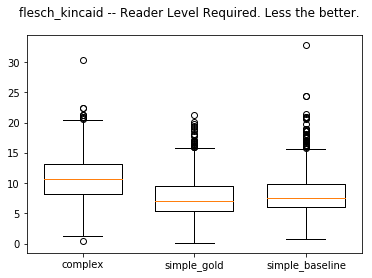

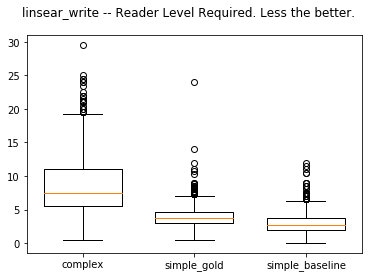

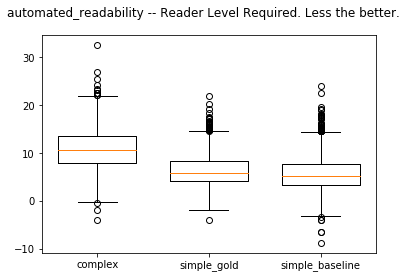

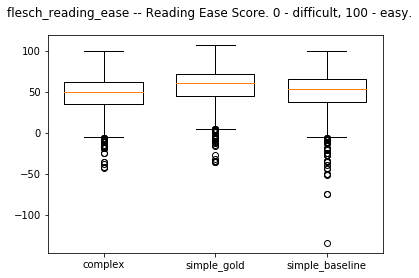

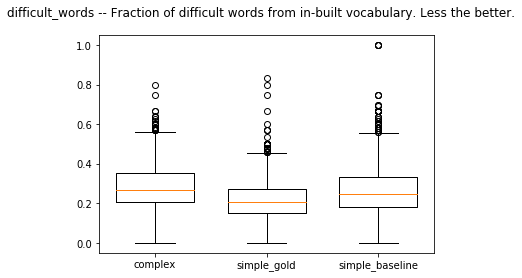

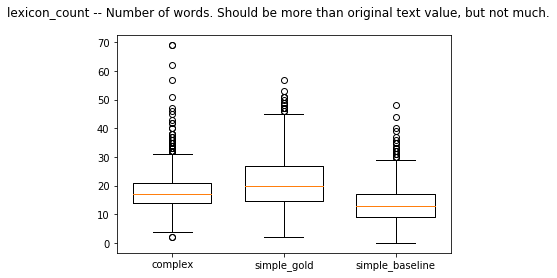

In [157]:
## main 4 ##

metrics_trends = {}
metrics_trends["lexicon_count"] = "Number of words. Should be more than original text value, but not much."
metrics_trends["flesch_reading_ease"] = "Reading Ease Score. 0 - difficult, 100 - easy."
metrics_trends["flesch_kincaid"] = "Reader Level Required. Less the better."
metrics_trends["automated_readability"] = "Reader Level Required. Less the better."
metrics_trends["difficult_words"] = "Fraction of difficult words from in-built vocabulary. Less the better."
metrics_trends["linsear_write"] = "Reader Level Required. Less the better."

for name, results in simplicity_metrics.iteritems():
    fig = plt.figure()
    titles = ["complex", "simple_gold", "simple_baseline"]
    data = [results["compl"], results["simple_gold"], results["baseline"]]
    plt.boxplot(data, positions = [1,2,3], widths = 0.7)
    plt.xticks([1,2,3], titles)
    fig.suptitle(name + ' -- ' + metrics_trends[name])


# Calculate similarity metrics

In [158]:
# save results to text files readable for metrics lib
with open("../dataset/test_simple.txt", "w") as h:
    for compl, sim in test.iteritems():
        if (len(sim) > 10) and (len(baseline_result[compl]) > 10):
            sim = sim.replace("\n", "")
            sim += "\n"
            h.write(sim.encode('utf-8'))
          
with open("../dataset/test_baseline.txt", "w") as r:
    for compl, sim in test.iteritems():
        if (len(sim) > 10) and (len(baseline_result[compl]) > 10):
            line = baseline_result[compl]
            line = line.replace("\n", "")
            line += "\n"
            r.write(line.encode('utf-8'))

In [159]:
# check number of lines are equal
with open("../dataset/test_simple.txt", "r") as h:
    l = h.readlines()
    print len(l)
with open("../dataset/test_baseline.txt", "r") as r:
    l = r.readlines()
    print len(l)

1340
1340


In [160]:
# calculate metrics for correspondence of generated sentence to gold-simple sentences
metrics_dict = compute_metrics(hypothesis="../dataset/test_baseline.txt",
                               references=["../dataset/test_simple.txt"])

Bleu_1: 0.405793
Bleu_2: 0.314038
Bleu_3: 0.252190
Bleu_4: 0.205916
METEOR: 0.245252
ROUGE_L: 0.428148
CIDEr: 1.254691
SkipThoughtsCosineSimilairty: 0.819136
EmbeddingAverageCosineSimilairty: 0.864031
VectorExtremaCosineSimilarity: 0.675512
GreedyMatchingScore: 0.889118


# Calculate adequacy to the language model

In [151]:
# load the English language model
LM = os.path.join(os.path.dirname("__file__"), '..', 'lm', 'lm_csr_64k_nvp_3gram.arpa')
model = kenlm.LanguageModel(LM)
print('{0}-gram model'.format(model.order))

3-gram model


In [163]:
# collect matching scores of all texts
gold_scores = []
baseline_scores = []

for compl, sim in test.iteritems():
    doc = nlp(sim.decode('utf-8'), disable=['ner', 'textcat', 'parser'])
    gold_scores.append((model.score(sim))/len(doc))

    simple_text = baseline_result[compl]
    doc_s = nlp(simple_text.decode('utf-8'), disable=['ner', 'textcat', 'parser'])
    if len(doc_s) > 0:
        baseline_scores.append((model.score(simple_text))/len(doc_s))


([<matplotlib.axis.XTick at 0x7f0a62297fd0>,
 <a list of 2 Text xticklabel objects>)

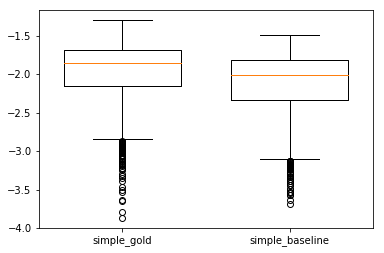

In [164]:
# display results
fig = plt.figure()
titles = ["simple_gold", "simple_baseline"]
data = [gold_scores, baseline_scores]
plt.boxplot(data, positions = [1,2], widths = 0.7)
plt.xticks([1,2], titles)